# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [23]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [6]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

Objective: To construct a co-occurrence matrix from top 2k and 5k words respectively from tf-idf. Then, finding the matrices
           using Truncated SVD, U, Σ, V and then appying K-Means++ on different values of 'K' and take insights from the 
           respective clusters and plot WordCloud for each Cluster.

In [3]:
connect=sqlite3.connect('final.sqlite')


In [4]:
cleaned_data= pd.read_sql_query("select * from cleaned", connect)

In [5]:
cleaned_data['Time'] = pd.to_datetime(cleaned_data['Time'], unit = 's')
cleaned_data= cleaned_data.sort_values(by='Time')

In [6]:
X = cleaned_data['processed_review']

In [31]:
tfidf= TfidfVectorizer(max_features=30000,use_idf=True, ngram_range=(1,1))
tfidf_train = tfidf.fit_transform(X)


#normalize the data 
from sklearn import preprocessing
tfidf_train = preprocessing.normalize(tfidf_train)


In [32]:
print("After Vectorization")
print(tfidf_train.shape)


After Vectorization
(348260, 30000)


## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [3]:
# Please write all the code with proper documentation

In [36]:
#https://stackoverflow.com/questions/25217510/how-to-see-top-n-entries-of-term-document-matrix-after-tfidf-in-scikit-learn

index = np.argsort(tfidf.idf_)
feature = tfidf.get_feature_names()
#feature
#index

In [39]:
top = [(feature[i],tfidf.idf_[i]) for i in index[:2000]]


In [41]:
top_features = pd.DataFrame(data=top, columns =['Top feature','TFIDF Score'])

In [47]:
top_features.head(5)

,Top feature,TFIDF Score
0,not,1.613387
1,like,2.233189
2,good,2.333013
3,great,2.414829
4,one,2.521798


In [53]:
print(top_features[0:1])

  Top feature  TFIDF Score
0         not     1.613387


### [5.2] Calulation of Co-occurrence matrix

In [3]:
# Please write all the code with proper documentation

In [71]:
#Github truncated SVD code was considered as reference code and few chanegs were made.
# We will consider a window size of 2, the co occurence matrix is formed by checking how many times the two words co existed in the given window.

# we will form the corpus of 2000 dimension using the top features

dim = top_features.shape[0]

#create a zero co occurence matrix of size dim
matrix = np.zeros((dim,dim),int)

# let's create a dictonary with the values as TIDF score and key as the feature name for 2000 top features. We will use these as lookup table for creating co-occurence matrix
values = [i for i in range(0,top_features.shape[0])]
#values
keys = [str(i) for i in top_features['Top feature']]
#keys
lookup = dict(zip(values,keys))
#lookup
words_top = keys

#Lets define window size as 2
window = 2
# Lets split the reviews in X train into single words and apply the window to generate the cooccurence matrix
for review in tqdm(X):
    word_review = review.split()
    for index, word in enumerate(word_review):
        if word in keys:
             for j in range(max(index-window,0),min(index+window,len(word_review)-1) + 1):
                    if word_review[j] in keys:
                        matrix[keys.index(word),keys.index(word_review[j])] += 1
                    else:
                        continue
        else:
            continue
            
    



  1%|▋                                                                          | 3185/348260 [00:15<27:23, 210.01it/s]


  2%|█▌                                                                         | 7452/348260 [00:31<16:10, 351.14it/s]


  4%|██▋                                                                       | 12445/348260 [00:46<18:49, 297.33it/s]


  5%|███▌                                                                      | 16933/348260 [01:02<18:19, 301.40it/s]


  6%|████▌                                                                     | 21722/348260 [01:17<20:43, 262.52it/s]


  8%|█████▌                                                                    | 26399/348260 [01:33<18:54, 283.78it/s]


  9%|██████▍                                                                   | 30508/348260 [01:48<19:40, 269.10it/s]


 10%|███████▍                                                                  | 34763/348260 [02:04<22:36, 231.16it/s]


 11%|████████▎                                                                 | 38869/348260 [02:19<24:55, 206.84it/s]


 12%|█████████▏                                                                | 43131/348260 [02:35<18:51, 269.55it/s]


 14%|█████████▉                                                                | 47040/348260 [02:50<18:48, 266.99it/s]


 15%|██████████▉                                                               | 51527/348260 [03:06<16:23, 301.82it/s]


 16%|███████████▊                                                              | 55815/348260 [03:21<17:24, 279.97it/s]


 17%|████████████▋                                                             | 59699/348260 [03:37<21:00, 228.89it/s]


 18%|█████████████▌                                                            | 63838/348260 [03:52<19:31, 242.80it/s]


 20%|██████████████▍                                                           | 67945/348260 [04:08<18:51, 247.81it/s]


 21%|███████████████▎                                                          | 72253/348260 [04:23<16:43, 274.92it/s]


 22%|████████████████▏                                                         | 76308/348260 [04:38<19:01, 238.26it/s]


 23%|█████████████████▏                                                        | 80649/348260 [04:53<16:48, 265.35it/s]


 24%|██████████████████                                                        | 84802/348260 [05:09<14:15, 308.12it/s]


 26%|██████████████████▊                                                       | 88815/348260 [05:24<17:23, 248.54it/s]


 27%|███████████████████▊                                                      | 93118/348260 [05:39<16:33, 256.93it/s]


 28%|████████████████████▋                                                     | 97220/348260 [05:54<15:13, 274.67it/s]


 29%|█████████████████████▏                                                   | 101307/348260 [06:10<16:55, 243.11it/s]


 30%|██████████████████████                                                   | 105327/348260 [06:25<14:17, 283.28it/s]


 31%|██████████████████████▉                                                  | 109375/348260 [06:40<13:51, 287.47it/s]


 33%|███████████████████████▊                                                 | 113511/348260 [06:56<14:47, 264.39it/s]


 34%|████████████████████████▌                                                | 117408/348260 [07:11<15:02, 255.86it/s]


 35%|█████████████████████████▍                                               | 121166/348260 [07:27<18:28, 204.81it/s]


 36%|██████████████████████████▏                                              | 125065/348260 [07:42<12:51, 289.35it/s]


 37%|███████████████████████████                                              | 129042/348260 [07:57<12:12, 299.45it/s]


 38%|███████████████████████████▊                                             | 132852/348260 [08:12<13:18, 269.63it/s]


 39%|████████████████████████████▋                                            | 136678/348260 [08:27<13:05, 269.19it/s]


 40%|█████████████████████████████▍                                           | 140254/348260 [08:42<13:54, 249.23it/s]


 41%|██████████████████████████████▏                                          | 144066/348260 [08:58<13:31, 251.57it/s]


 42%|██████████████████████████████▉                                          | 147723/348260 [09:13<13:19, 250.72it/s]


 44%|███████████████████████████████▊                                         | 151571/348260 [09:28<13:17, 246.69it/s]


 45%|████████████████████████████████▌                                        | 155320/348260 [09:44<13:50, 232.28it/s]


 46%|█████████████████████████████████▎                                       | 159158/348260 [09:59<15:17, 206.15it/s]


 47%|██████████████████████████████████▏                                      | 163048/348260 [10:14<13:22, 230.73it/s]


 48%|██████████████████████████████████▉                                      | 166960/348260 [10:30<14:33, 207.47it/s]


 49%|███████████████████████████████████▊                                     | 170620/348260 [10:45<12:28, 237.31it/s]


 50%|████████████████████████████████████▌                                    | 174501/348260 [11:00<10:45, 269.08it/s]


 51%|█████████████████████████████████████▎                                   | 177966/348260 [11:16<12:55, 219.66it/s]


 52%|██████████████████████████████████████                                   | 181595/348260 [11:31<12:22, 224.53it/s]


 53%|██████████████████████████████████████▉                                  | 185752/348260 [11:46<10:22, 260.93it/s]


 55%|███████████████████████████████████████▊                                 | 189949/348260 [12:01<09:55, 266.00it/s]


 56%|████████████████████████████████████████▋                                | 194013/348260 [12:16<09:21, 274.54it/s]


 57%|█████████████████████████████████████████▌                               | 197988/348260 [12:32<08:53, 281.84it/s]


 58%|██████████████████████████████████████████▎                              | 202157/348260 [12:47<08:05, 300.94it/s]


 59%|███████████████████████████████████████████▏                             | 205914/348260 [13:03<10:53, 217.78it/s]


 60%|███████████████████████████████████████████▉                             | 209704/348260 [13:18<09:32, 241.95it/s]


 61%|████████████████████████████████████████████▊                            | 213689/348260 [13:33<06:52, 326.58it/s]


 62%|█████████████████████████████████████████████▌                           | 217657/348260 [13:49<07:53, 275.73it/s]


 64%|██████████████████████████████████████████████▌                          | 221953/348260 [14:04<08:31, 246.93it/s]


 65%|███████████████████████████████████████████████▍                         | 226360/348260 [14:19<07:30, 270.44it/s]


 66%|████████████████████████████████████████████████▎                        | 230536/348260 [14:34<08:39, 226.71it/s]


 67%|█████████████████████████████████████████████████▏                       | 234755/348260 [14:49<07:31, 251.37it/s]


 69%|██████████████████████████████████████████████████                       | 238583/348260 [15:05<06:27, 283.02it/s]


 70%|██████████████████████████████████████████████████▊                      | 242368/348260 [15:20<06:06, 288.71it/s]


 71%|███████████████████████████████████████████████████▌                     | 246148/348260 [15:36<06:59, 243.69it/s]


 72%|████████████████████████████████████████████████████▎                    | 249841/348260 [15:51<07:30, 218.48it/s]


 73%|█████████████████████████████████████████████████████▏                   | 253668/348260 [16:06<05:23, 292.69it/s]


 74%|██████████████████████████████████████████████████████                   | 257624/348260 [16:22<05:30, 274.15it/s]


 75%|██████████████████████████████████████████████████████▊                  | 261326/348260 [16:37<06:07, 236.41it/s]


 76%|███████████████████████████████████████████████████████▌                 | 265087/348260 [16:52<05:20, 259.57it/s]


 77%|████████████████████████████████████████████████████████▍                | 269214/348260 [17:07<04:59, 263.93it/s]


 78%|█████████████████████████████████████████████████████████▏               | 273028/348260 [17:23<05:04, 247.27it/s]


 79%|██████████████████████████████████████████████████████████               | 276864/348260 [17:38<05:29, 216.89it/s]


 81%|██████████████████████████████████████████████████████████▊              | 280639/348260 [17:54<04:07, 273.13it/s]


 82%|███████████████████████████████████████████████████████████▋             | 284461/348260 [18:09<04:44, 224.06it/s]


 83%|████████████████████████████████████████████████████████████▍            | 288150/348260 [18:24<04:39, 215.33it/s]


 84%|█████████████████████████████████████████████████████████████▏           | 292003/348260 [18:40<03:27, 270.98it/s]


 85%|██████████████████████████████████████████████████████████████           | 295795/348260 [18:55<03:20, 261.29it/s]


 86%|██████████████████████████████████████████████████████████████▊          | 299797/348260 [19:10<02:52, 280.31it/s]


 87%|███████████████████████████████████████████████████████████████▋         | 303755/348260 [19:26<02:48, 264.72it/s]


 88%|████████████████████████████████████████████████████████████████▍        | 307403/348260 [19:41<02:46, 245.35it/s]


 89%|█████████████████████████████████████████████████████████████████▏       | 311153/348260 [19:56<02:00, 307.83it/s]


 91%|██████████████████████████████████████████████████████████████████       | 315287/348260 [20:12<01:59, 276.62it/s]


 92%|██████████████████████████████████████████████████████████████████▉      | 319221/348260 [20:27<01:45, 275.25it/s]


 93%|███████████████████████████████████████████████████████████████████▋     | 323112/348260 [20:42<01:36, 261.71it/s]


 94%|████████████████████████████████████████████████████████████████████▋    | 327434/348260 [20:57<01:15, 277.51it/s]


 95%|█████████████████████████████████████████████████████████████████████▍   | 331532/348260 [21:13<01:11, 234.22it/s]


 96%|██████████████████████████████████████████████████████████████████████▎  | 335554/348260 [21:28<00:44, 288.03it/s]


 98%|███████████████████████████████████████████████████████████████████████▏ | 339812/348260 [21:43<00:28, 293.79it/s]


 99%|████████████████████████████████████████████████████████████████████████▏| 344156/348260 [21:58<00:13, 299.14it/s]


100%|█████████████████████████████████████████████████████████████████████████| 348260/348260 [22:12<00:00, 261.34it/s]

### [5.3] Finding optimal value for number of components (n) to be retained.

In [3]:
# Please write all the code with proper documentation

In [ ]:
# You should choose the n_components in truncated svd, with maximum explained variance. 
#Please search on how to choose that and implement them. 
#(hint: plot of cumulative explained variance ratio)

In [73]:
from sklearn.decomposition import TruncatedSVD

In [74]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

svd = TruncatedSVD(n_components= 1500, algorithm='randomized',n_iter=10,random_state=0)
svd_fit = svd.fit_transform(matrix)

cum_var = np.cumsum(svd. explained_variance_ratio_)


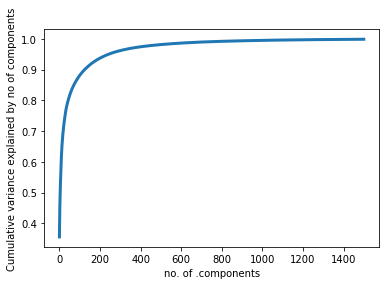

In [77]:
plt.plot(cum_var, linewidth=3)
plt.xlabel('no. of .components')
plt.ylabel('Cumulative variance explained by no of components')
plt.show()


It is observed that around 400 components are enough to explain 100% variance. So, instaed of 1500 components we will use 400 components

In [98]:
svd = TruncatedSVD(n_components = 400,algorithm='randomized',n_iter=10,random_state=0)
svd_model=svd.fit_transform(matrix)

### [5.4] Applying k-means clustering

In [3]:
# Please write all the code with proper documentation

In [99]:
# After you are done with the truncated svd, you can apply K-Means clustering and 
#choose the best number of clusters 
#based on elbow method.
from sklearn.cluster import KMeans
k= [2,3,4,5,6,7,8,10,12,15,16]
inertia = []
for i in k:
    k_means = KMeans(n_clusters =i, random_state= 0).fit(svd_model)
    inertia.append(k_means.inertia_)

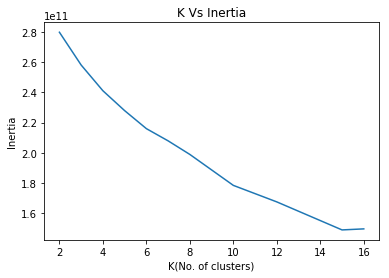

In [100]:
plt.plot(k,inertia)
plt.xlabel('K(No. of clusters)')
plt.ylabel('Inertia')
plt.title('K Vs Inertia')
plt.show()

from the above plot, K=9 will be the optimal cluster size.

In [103]:
opt_k = 9
k_means = KMeans(n_clusters =opt_k, random_state= 0).fit(svd_model)

### [5.5] Wordclouds of clusters obtained in the above section

In [3]:
# Please write all the code with proper documentation

In [ ]:
# Print out wordclouds for each cluster, similar to that in previous assignment.

In [104]:
rev = X.values

In [115]:
clust= [ [] for i in range(opt_k)]
for i in range(k_means.labels_.shape[0]):
    clust[k_means.labels_[i]].append(rev[i])

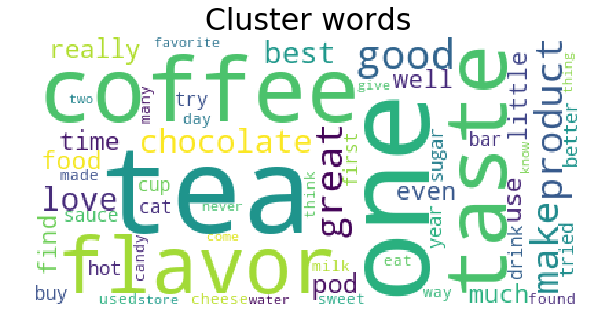

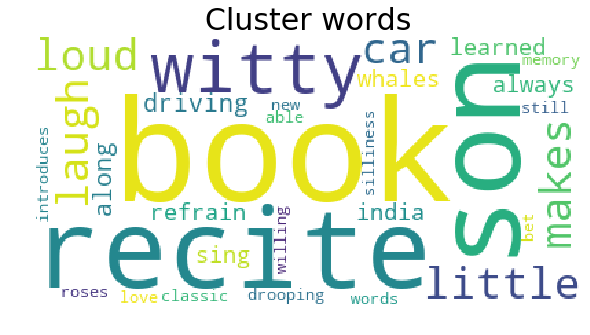

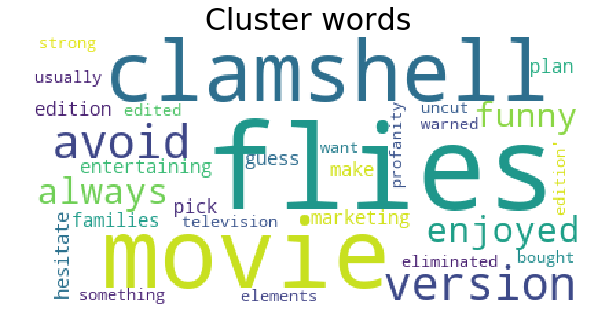

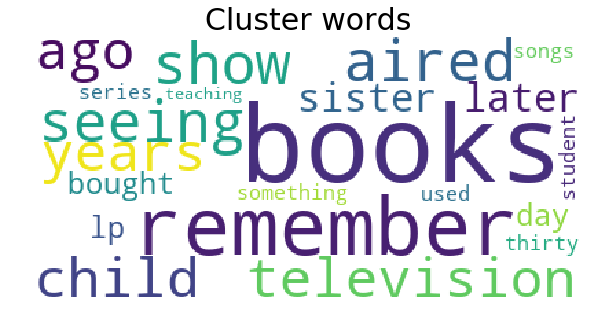

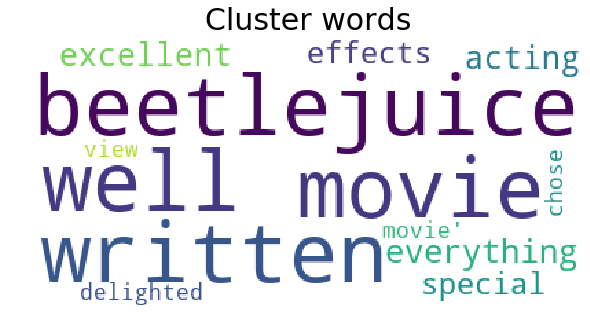

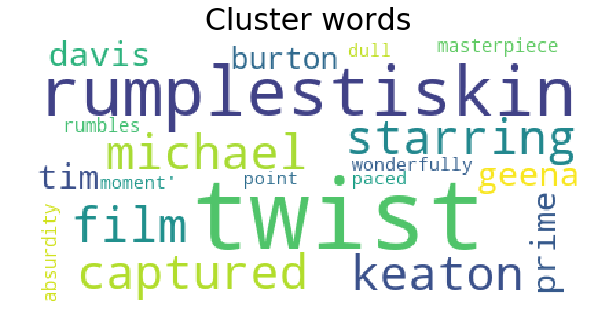

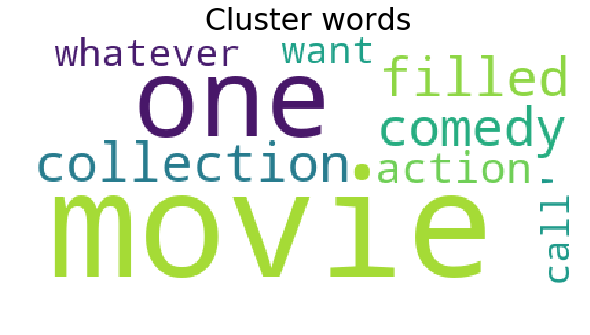

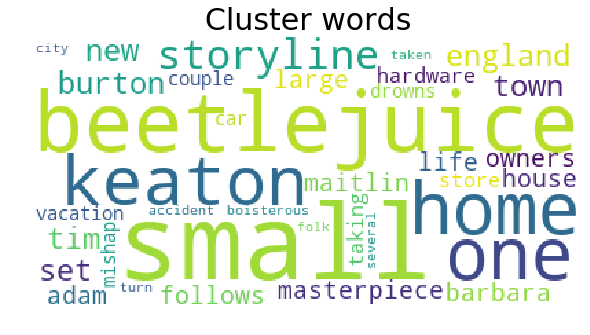

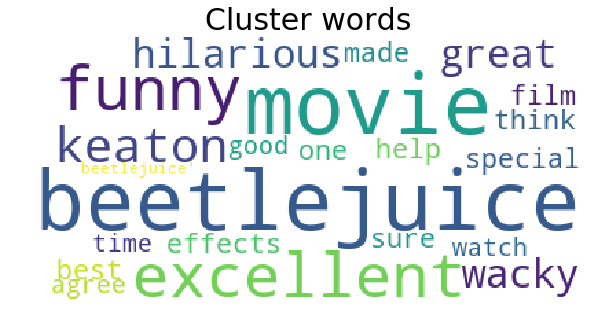

In [124]:
from wordcloud import WordCloud
# https://www.geeksforgeeks.org/generating-word-cloud-python/
def cloud(cluster):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster)))
    plt.figure(figsize = (8,8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster words",size= 30,)
    plt.show() 
for cl in clust:
    cloud(cl)

## Inference:

Cluster 1 has words like tea, coffee, flavour which explains food and its review.
Cluster 2 has words like book, recite, memory which explains terms related to books and learning.
Cluster 3 has words like movie,entertaining, television which explains terms related to entertainment.
Cluster 4 has words like aired, tv,songs, series which explains terms related to shows in TV.
Cluster 5 has words like movie, written, acting and words related to movie and acting.
Cluster 6 has words like film, michael, starring which explains about the movies and starrer.
Cluster 7 has words like movie, collection, comedy which explains the genre of movies 
Cluster 8 has words like juice, beetle, barbara which is not that clear
Cluster 9 has words like movie, hilarious, effects which explains positve reviews about some movie.

### [5.6] Function that returns most similar words for a given word.

In [3]:
# Please write all the code with proper documentation

In [ ]:
# You need to write a function that takes a word and returns the most similar words 
#using cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)

In [129]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(svd_model,svd_model)
sim.shape

(2000, 2000)

In [147]:
def near_word(word, neigh):
    feat_words = top_features['Top feature']
    #feat_words
    temp = np.where(feat_words==word)[0]
    if (len(temp)>0):
        index=temp[0]
    #lets create a dataframe to dump the similar word
        df= pd.DataFrame()
        df['words']=feat_words
        df['val']=sim[index,:]
        #we need to sort the values
        df=df.sort_values(by='val',ascending=False)
        return list(df.head(neigh)['words'])
        
    

In [176]:
print("Similar word to '{}':".format(top_features['Top feature'][13]))
print(near_word(top_features['Top feature'][13],10))

print("Similar word to '{}':".format(top_features['Top feature'][5]))
print(near_word(top_features['Top feature'][5],10))

print("Similar word to '{}':".format(top_features['Top feature'][50]))
print(near_word(top_features['Top feature'][50],10))

print("Similar word to '{}':".format(top_features['Top feature'][500]))
print(near_word(top_features['Top feature'][500],10))

Similar word to 'amazon':
['amazon', 'com', 'thru', 'via', 'offers', 'prime', 'offering', 'offered', 'sells', 'selling']
Similar word to 'taste':
['taste', 'buds', 'test', 'chemical', 'funny', 'strange', 'wise', 'wild', 'slight', 'odd']
Similar word to 'order':
['order', 'placed', 'mail', 'auto', 'recent', 'directly', 'receive', 'vendor', 'future', 'receiving']
Similar word to 'teeth':
['teeth', 'clean', 'cleaning', 'breath', 'chewing', 'stick', 'system', 'bones', 'keeping', 'prevent']


## observation
1. We input the word and we are calculating the 10 similar words based on the distances calculated.

For example, similar words for AMAZON are PRIME, OFFERS,SELLING,SELL.

the similarity seems to work fine. But still it can be optimised.


# [6] Conclusions

In [1]:
# Please write down few lines about what you observed from this assignment. 
# Also please do mention the optimal values that you obtained for number of components & number of clusters.

## Steps carried out:

1. we took top 2000 words with high TFIDF score.
2. We computed the co occurence matrix by considering window size of 2. Meaning the co occurence matrix will have values of a word which will occur in the selectd window.
3. By plotting the no.of components (2000) Vs the variance, it is found that 400 components are sufficent to explain the variance instead of 2000 components.
4. We applied the K means clustering on the SVD model and selected K=9 based on the elbow method.
5. We plotted the 9 clusters.
6. used the cosine similarity ( distance) to find the similar words for input word.
